# 3. Claim frequency and severity regression

We will now predict claim frequency and severity in the MTPL data with a neural network.

In [1]:
# load libs
import os
import numpy as np
import pandas as pd
import graphviz
import random
import tensorflow as tf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import statsmodels.gam.smooth_basis
from statsmodels.gam.api import GLMGam, BSplines
from sklearn.model_selection import train_test_split

def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(123)
    tf.random.set_seed(123)
    np.random.seed(123)
    random.seed(123)

In [2]:
# load data using separator to correctly parse from .txt
df = pd.read_csv(os.path.join(os.getcwd(),"data\PC_data.txt"),  sep=r"\s+")

In [3]:
# column names to smaller case
df.columns = map(str.lower, df.columns)

In [4]:
# rename exp to expo
df.rename(columns={'exp':'expo'}, inplace = True); df.head()

,id,nclaims,amount,avg,expo,coverage,fuel,use,fleet,sex,ageph,bm,agec,power,pc,town,long,lat
0,1,1,1618.001036,1618.001036,1.000000,TPL,gasoline,private,N,male,50,5,12,77,1000,BRUSSEL,4.355223,50.845386
1,2,0,0.000000,NaN,1.000000,PO,gasoline,private,N,female,64,5,3,66,1000,BRUSSEL,4.355223,50.845386
2,3,0,0.000000,NaN,1.000000,TPL,diesel,private,N,male,60,0,10,70,1000,BRUSSEL,4.355223,50.845386
3,4,0,0.000000,NaN,1.000000,TPL,gasoline,private,N,male,77,0,15,57,1000,BRUSSEL,4.355223,50.845386
4,5,1,155.974606,155.974606,0.046575,TPL,gasoline,private,N,female,28,9,7,70,1000,BRUSSEL,4.355223,50.845386


In [5]:
# train/test split using sklearn
train, test = train_test_split(df, test_size=0.25); print(f'train size:{train.shape}, test size:{test.shape}')

train size:(122423, 18), test size:(40808, 18)


In [6]:
# Reshuffling of the training observations
train = train.sample(frac = 1); print(f'train size:{train.shape}')

train size:(122423, 18)


Claim frequency is usually modelled via GLM with log-link function:

$$
\begin{align}
Y \sim Poisson(\lambda = \exp(x'\beta))
\end{align}
$$

We now redefine this model as a neural network:

<img src="./imgs/glm_vs_nn.jpg" width="440" height="440" align="center"/>

### 3.1 Claim frequency and severity regression

Consider a Poisson GLM model with only an intercept:

$$
\begin{align}
Y \sim Poisson(\lambda = \exp(1\cdot\beta))
\end{align}
$$

Let's fit a neural network with the following parametrization:
* **layer_dense**: there are no hidden layers, the input layer is directly connected to the output layer.
* **units = 1**: there is one output node.
* **activation = 'exponential'**: we use an exponential inverse link function.
* **input_shape = (1,)**: there is one input node, i.e., the intercept which will be constant one.
* **use_bias = FALSE**: we don't need a bias term, since we explicitly include an input node equal to one.
* **loss = 'poisson'**: we maximize the Poisson likelihood, i.e., minimize the Poisson deviance.

In [7]:
# neural network initialization
reset_random_seeds()
nn_freq_intercept = tf.keras.models.Sequential()
nn_freq_intercept.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', input_shape = (1,), use_bias = False))
nn_freq_intercept.compile(optimizer = 'RMSprop', loss = 'poisson')

**QUESTION:** how many parameters does this model have?

In [8]:
# answer
nn_freq_intercept.count_params()

1

In [9]:
# summary of the structure of the neural netweork
nn_freq_intercept.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 1         
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________


In [10]:
# create input/output vectors
intercept = np.ones(train.shape[0])
counts = np.array(train['nclaims'])
print(f'size of intercept vector: {intercept.shape[0]}, size of counts vector: {counts.shape[0]}')

size of intercept vector: 122423, size of counts vector: 122423


The **fit()** method shows the following parametrization:
* **x = intercept**: use the intercept as feature.
* **y = counts**: use the claim counts as target.
* **epochs = 20**: perform 20 training iterations over the complete data.
* **batch_size = 1024**: use batches with 1024 observations to update weights.
* **validation_split = 0**: don't use a validation set, so all observations are used for training.
* **verbose = 0**: silence keras such that no output is generated during fitting.


In [11]:
# fit the neural netword
nn_freq_intercept.fit(x = intercept,
                      y = counts,
                      epochs = 30,
                      batch_size = 1024,
                      validation_split = 0,
                      verbose = 0)

We compare the results of our neural network with the same model specified as a GLM:

In [12]:
glm_freq_intercept = sm.formula.glm("nclaims ~ 1", data=train, family=sm.families.Poisson()).fit(); glm_freq_intercept.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                nclaims   No. Observations:               122423
Model:                            GLM   Df Residuals:                   122422
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47918.
Date:                Fri, 08 Oct 2021   Deviance:                       67627.
Time:                        00:52:20   Pearson chi2:                 1.34e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0892      0.008   -257.186      0.000      -2.105      -2.073
==============================================================================
"""

In [13]:
# comparing the estimated parameter (difference reflects a different optimization technique)
print(f'NN weights:{np.float(nn_freq_intercept.get_weights()[0])}, \nGLM coefficients:{np.float(glm_freq_intercept.params)}')

NN weights:-2.0901336669921875, 
GLM coefficients:-2.0891517504125137


### 5.1.1 Your Turn!

**QUESTION 1:** adapt this code to replicate a **binomial** GLM with a **logit link function**. Add **accuracy** as a metric in your model. Consider the following hint:
* _Hint 1:_ the sigmoid activation function is the inverse of the logit link function.
* _Hint 2:_ the binary_crossentropy loss maximizes the loglikelihood of Bernoulli outcomes:
$$
\begin{align}
\sum^{n}_{i=1}{(y_{i}\cdot log(p_{i})+(1-y_{i})\cdot log(1-p_{i})).}
\end{align}
$$

In [14]:
reset_random_seeds()
exercize_nn = tf.keras.models.Sequential()
exercize_nn.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid', input_shape = (1,), use_bias = False))
exercize_nn.compile(optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

**QUESTION 2:** fit your neural network.

In [15]:
exercize_nn.fit(x = intercept,
                y = counts > 0, 
                epochs = 40, 
                batch_size = 1024, 
                validation_split = 0, 
                verbose = 0)

**QUESTION 3:** compare your fitted neural network with a GLM.
* _Hint 1:_To accomodate the fitting of the logistic regression of a categorical vector, we create a binary proxy variable nclaims_proxy with the following characteristics:
    * proxy = 0 when x = 0
    * proxy = 1 when x > 0

In [16]:
train['nclaims_proxy'] = np.where(train['nclaims'] > 0, 1, 0)

In [17]:
exercize_glm = sm.formula.glm("nclaims_proxy ~ 1 + 1", # it must be fitted this way or 0/1 labels get switched
                            data=train, 
                            family=sm.families.Binomial(sm.families.links.logit())).fit();

print(f'NN weights:{exercize_nn.get_weights()[0][0][0]}, \nGLM coefficients:{exercize_glm.params[0]}')

NN weights:-2.0772416591644287, 
GLM coefficients:-2.0739579557310837


In [18]:
exercize_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          nclaims_proxy   No. Observations:               122423
Model:                            GLM   Df Residuals:                   122422
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -42843.
Date:                Fri, 08 Oct 2021   Deviance:                       85686.
Time:                        00:52:26   Pearson chi2:                 1.22e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0740      0.009   -228.539      0.000      -2.092      -2.056
==============================================================================
"""

In [19]:
exercize_glm.predict()

array([0.11165386, 0.11165386, 0.11165386, ..., 0.11165386, 0.11165386,
       0.11165386])

In [20]:
# Q3: compare prediction
np.unique(np.round(exercize_glm.predict(),5))

array([0.11165])

In [21]:
np.unique(np.round(exercize_nn.predict(x = intercept),5))

array([0.11133], dtype=float32)

In [22]:
# we can now delete the proxy variable from the dataset
train = train.drop('nclaims_proxy',1)

### 5.2 Taking exposure into account in a neural network

The Poisson loss function, including exposure, is:
$$
\begin{align}
\mathcal{L}=\sum_{i}{expo_{i}\cdot \lambda_{i}-y_{i}\cdot log(expo_{i}\cdot \lambda_{i})},
\end{align}
$$
which is proportional to:
$$
\begin{align}
\mathcal{L}=\sum_{i}{expo_{i}\cdot (\lambda_{i}-\frac{y_{i}}{expo_{i}}log(\lambda_{i}))}.
\end{align}
$$

This is the loss of a Poisson model with:
* observations $\frac{y_{i}}{expo_{i}}$ and
* weights $expo_{i}$

Notice indeed how the parameter estimates of the following two GLMs are identical.

#### 5.2.1 Fitting GLM with offset component

In [23]:
# GLM with offset
glm_offset = sm.formula.glm("nclaims ~ ageph", 
                            data=train, 
                            offset = np.log(train.expo),
                            family=sm.families.Poisson()).fit(); 
glm_offset.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                nclaims   No. Observations:               122423
Model:                            GLM   Df Residuals:                   122421
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47441.
Date:                Fri, 08 Oct 2021   Deviance:                       66674.
Time:                        00:52:49   Pearson chi2:                 1.48e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2265      0.026    -46.346      0.000      -1.278      -1.175
ageph         -0.0163      0.001    -28.509      0.000      -0.017      -0.015
==============================================================================
"""

In [25]:
glm_offset.params

Intercept   -1.226496
ageph       -0.016343
dtype: float64

#### 5.2.2 Fitting GLM with weights

In [27]:
# GLM including weights
glm_weights = sm.formula.glm("nclaims ~ ageph", 
                             data=train, 
                             weights = train.expo, 
                             exposure = train.expo, 
                             family=sm.families.Poisson()).fit(); 
glm_weights.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                nclaims   No. Observations:               122423
Model:                            GLM   Df Residuals:                   122421
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47441.
Date:                Fri, 08 Oct 2021   Deviance:                       66674.
Time:                        00:52:58   Pearson chi2:                 1.48e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2265      0.026    -46.346      0.000      -1.278      -1.175
ageph         -0.0163      0.001    -28.509      0.000      -0.017      -0.015
==============================================================================
"""

In [28]:
glm_weights.params

Intercept   -1.226496
ageph       -0.016343
dtype: float64

#### 5.2.3 Fitting a neural network with exposure

The specification structure of the neural network remains the same:

In [29]:
# neural network architecture specification
reset_random_seeds()
nn_freq_exposure = tf.keras.models.Sequential()
nn_freq_exposure.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', input_shape = (1,), use_bias = False))
nn_freq_exposure.compile(optimizer = 'RMSprop', loss = 'poisson')

In [30]:
# create a vector with exposure values
exposure = np.array(train['expo']) # pd.Series must be converted to pd.array due to compatibility reasons with fit() method

In [31]:
# divide claim counts by exposure and use weights
nn_freq_exposure.fit(x = intercept,
                     y = counts/exposure,
                     sample_weight = exposure,
                     epochs = 20,
                     batch_size = 1024,
                     validation_split = 0,
                     verbose = 0)

In [32]:
nn_freq_exposure.get_weights()

[array([[-1.9758395]], dtype=float32)]

In [33]:
# comparing the estimated parameter (difference reflects a different optimization technique)
print(f'NN weights:{nn_freq_exposure.get_weights()[0][0][0]}, \n\nGLM_offset coefficients:{glm_offset.params}, \n\nGLM_weights coefficients:{glm_weights.params}')

NN weights:-1.9758394956588745, 

GLM_offset coefficients:Intercept   -1.226496
ageph       -0.016343
dtype: float64, 

GLM_weights coefficients:Intercept   -1.226496
ageph       -0.016343
dtype: float64


### 5.3 How can we include exposure via an offset term?

In [34]:
# create a vector with ageph (pd.Series must be converted to pd.array due to compatibility reasons with fit() method)
ageph = np.array(train['ageph'])

In [35]:
# neural network architecture specification
reset_random_seeds()
nn_freq_ageph = tf.keras.models.Sequential()
nn_freq_ageph.add(tf.keras.layers.BatchNormalization(input_shape = (1,))) # layer_batch_normalization centers and scales the input features
nn_freq_ageph.add(tf.keras.layers.Dense(units = 5, activation = 'tanh'))
nn_freq_ageph.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', use_bias = True)) # Notice how we set use_bias = TRUE for the intercept.
nn_freq_ageph.compile(optimizer = 'RMSprop', loss = 'poisson')

In [36]:
nn_freq_ageph.fit(ageph,
                 counts/exposure,
                 sample_weight = exposure,
                 epochs = 20,
                 batch_size = 1024,
                 validation_split = 0,
                 verbose = 0)

In [37]:
nn_freq_ageph.get_weights()

[array([0.6598984], dtype=float32),
 array([0.39028922], dtype=float32),
 array([47.011456], dtype=float32),
 array([219.40276], dtype=float32),
 array([[-0.49004763,  0.14843556, -0.27004567,  0.04346556,  0.40451518]],
       dtype=float32),
 array([-0.39765945,  0.36914247, -0.37699124, -0.36679944, -0.37364745],
       dtype=float32),
 array([[ 0.97479665],
        [-1.0621016 ],
        [ 0.784981  ],
        [ 0.74881494],
        [ 0.69293696]], dtype=float32),
 array([-0.36167932], dtype=float32)]

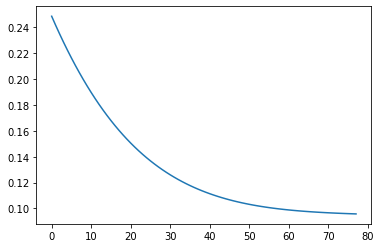

In [38]:
age = tf.cast(np.array(range(18,96)), tf.float32)
nn_pred = nn_freq_ageph.predict(age)
plt.plot(nn_pred)

### Applying GAM models

In [48]:
bs = statsmodels.gam.smooth_basis.BSplines(train['ageph'], 
                                           df = [9,9], 
                                           degree = [2,2],
                                           include_intercept=True)

In [49]:
gam_bs = GLMGam.from_formula('nclaims ~ 1', 
                             data=train, 
                             smoother=bs, 
                             family=sm.families.Poisson(sm.families.links.log()),
                             offset = np.log(train.expo)).fit();
gam_bs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                nclaims   No. Observations:               122423
Model:                         GLMGam   Df Residuals:                   122414
Model Family:                 Poisson   Df Model:                         8.00
Link Function:                    log   Scale:                          1.0000
Method:                         PIRLS   Log-Likelihood:                -47374.
Date:                Fri, 08 Oct 2021   Deviance:                       66538.
Time:                        00:54:30   Pearson chi2:                 1.47e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7014      0.022    -75.947      0.000      -1.745      -1.658
ageph_s0       0.5606      0.094      5.979      0.000       0.377       0.744
ageph_s1       0.2508      0.060      4.190      0.000       0.133       0.368
ageph_s2      -0.1911      0.039     -4.921      0.000      -0.267      -0.115
ageph_s3      -0.3037      0.041     -7.386      0.000      -0.384      -0.223
ageph_s4      -0.2529      0.040     -6.301      0.000      -0.332      -0.174
ageph_s5      -0.3454      0.044     -7.895      0.000      -0.431      -0.260
ageph_s6      -0.5512      0.040    -13.646      0.000      -0.630      -0.472
ageph_s7      -0.8258      0.108     -7.677      0.000      -1.037      -0.615
ageph_s8      -0.0428      0.233     -0.184      0.854      -0.499       0.414
==============================================================================
"""

In [51]:
gam_bs.predict(exog = pd.DataFrame(np.ones(train.shape[0])),  exog_smooth = np.array(train['ageph']))

0         0.135740
1         0.123853
2         0.131501
3         0.137239
4         0.105474
            ...   
122418    0.177333
122419    0.131501
122420    0.095534
122421    0.095534
122422    0.141827
Length: 122423, dtype: float64

In [52]:
# creating dataframe
df_plot = pd.DataFrame({'ageph':np.array(range(18,96)),
                  'nn_pred':np.array([float(x) for x in list(nn_pred)])})

In [53]:
df_plot['gam_pred'] = gam_bs.predict(exog = pd.DataFrame(np.ones(df_plot.shape[0])),  exog_smooth = np.array(df_plot['ageph'])) 
df_plot.head()

,ageph,nn_pred,gam_pred
0,18,0.248705,0.319549
1,19,0.241770,0.303535
2,20,0.235078,0.288446
3,21,0.228622,0.274224
4,22,0.222401,0.260814


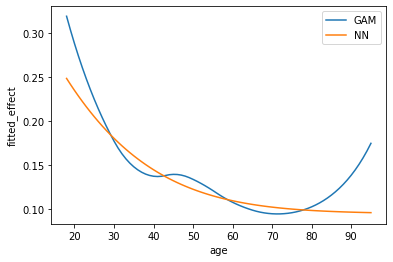

In [54]:
plt.plot(df_plot.ageph, df_plot.gam_pred, label = "GAM")
plt.plot(df_plot.ageph, df_plot.nn_pred, label = "NN")
plt.xlabel('age')
plt.ylabel('fitted_effect')
plt.legend()
plt.show()

### Adding a skip connection in a neural network

So far, we stayed in a purely sequential architecture with tf.keras.models.Sequential().Now, we will allow some input nodes to be connected directly to the output node, i.e., skip connections.

<figure>
<img src="./imgs/skip_conn.png" alt="autoencoder_schema" style="width: 300px;"/>
<figcaption><center>Figure taken from <a href="https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3320525">Schelldorfer and Wuthrich (2019)</a>.<p></p></center></figcaption>
</figure>

The output node, without skip connection, calculates:
$$
\begin{align}
f_{activation}{(\sum_{i}w_{i}h_{i}+b)}.
\end{align}
$$

With a skip connection, this simply becomes:
$$
\begin{align}
f_{activation}{(\sum_{i}w_{i}h_{i}+b+s)}.
\end{align}
$$

We take a linear combination of the last hidden layer outputs and add the skip input, before applying the activation function.
So, what can we do with this? Let's take a claim frequency example with the exponential activation function:
* Adding exposure as an offset term:
$$
\begin{align}
output = \exp{(\sum_{i}w_{i}h_{i}+b+log(expo))} = expo\cdot \exp(\sum_{i}w_{i}h_{i}+b)
\end{align}
$$
* Adding a base prediction:
$$
\begin{align}
output = \exp{(\sum_{i}w_{i}h_{i}+b+log(base))} = base\cdot \exp(\sum_{i}w_{i}h_{i}+b)
\end{align}
$$
* The combination of both:
$$
\begin{align}
output = \exp{(\sum_{i}w_{i}h_{i}+b+log(expo\cdot base))} = expo\cdot base\cdot \exp(\sum_{i}w_{i}h_{i}+b)
\end{align}
$$

A skip connection allows us to guide the neural net in the right direction and to model adjustments on top of the base
predictions, for example obtained via a GLM or GAM. In the actuarial lingo this is called a Combined Actuarial Neural Network
(CANN).

In [55]:
reset_random_seeds()

# create two input layers via layer_input, one for the skip connection and one for the neural network
input_nn = tf.keras.layers.Input(shape = (1,), name = 'nn')
input_skip = tf.keras.layers.Input(shape = (1,), name = 'skip')

# specify the architecture to use for the neural net part with a linear combination of the hidden nodes as output
norm_nn = tf.keras.layers.BatchNormalization()(input_nn)
dense_1 = tf.keras.layers.Dense(units = 5, activation = 'tanh')(norm_nn)
network = tf.keras.layers.Dense(units = 1, activation = 'linear')(dense_1)

# combine the neural network and skip connection via layer_add and pass through the exponential function with fixed weights
interm = tf.keras.layers.Add()([network, input_skip])

# output layer
init = tf.constant_initializer(np.ones((1,1)))
output = tf.keras.layers.Dense(units = 1, 
                               activation = 'exponential', 
                               trainable = False,
                               kernel_initializer = init,
                               name = 'output')(interm)

In [56]:
# Define the full model with inputs and output via keras_model and compile as usual
cann = tf.keras.models.Model(inputs = [input_nn, input_skip], outputs = output)
cann.compile(optimizer = 'RMSprop', loss = 'poisson')

Tensorflow is endowed with a specific utility to visualize the structure of the network. We can indeed see the skip connection via layer_add:

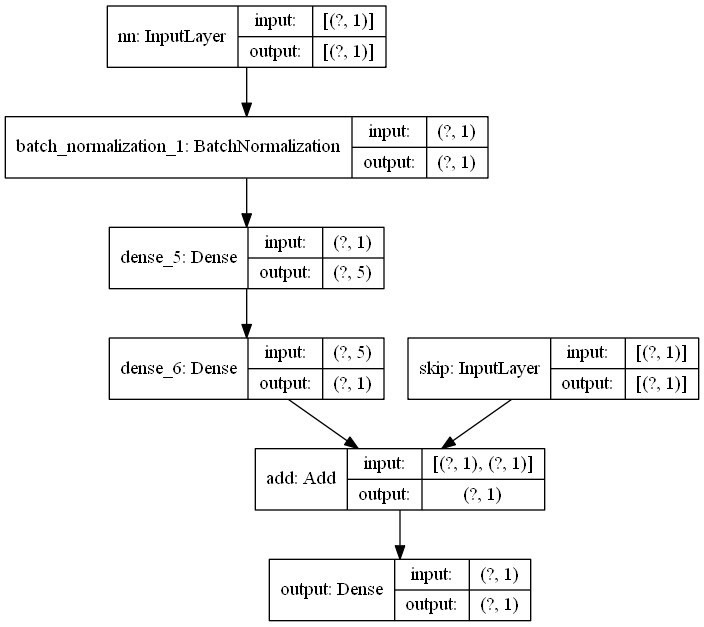

In [57]:
# model structure
tf.keras.utils.plot_model(model=cann, show_shapes=True, to_file='./imgs/model.png')

Calculate the GAM base predictions, including exposure:

In [58]:
gam_expo = np.log(gam_bs.predict()) + np.log(train['expo']); gam_expo

42811    -1.997017
37497    -2.088663
1592     -4.873864
37309    -1.986033
129395   -2.249292
            ...   
62168    -3.317632
88947    -2.028743
79145    -7.280095
141900   -2.348275
120903   -3.039772
Name: expo, Length: 122423, dtype: float64

Collect the CANN input data in a named list:

In [59]:
#cann_input = {'nn':np.array(train['ageph']), 'skip':np.array(gam_expo)}
cann_input = [np.array(train['ageph']), np.array(gam_expo)]

In [60]:
gam_expo

42811    -1.997017
37497    -2.088663
1592     -4.873864
37309    -1.986033
129395   -2.249292
            ...   
62168    -3.317632
88947    -2.028743
79145    -7.280095
141900   -2.348275
120903   -3.039772
Name: expo, Length: 122423, dtype: float64

Fit the CANN like we have seen before:

In [61]:
cann.fit(x = cann_input,
         y = counts,
         epochs = 20,
         batch_size = 1024,
         validation_split = 0,
         verbose = 1)

Train on 122423 samples
Epoch 1/20
122423/122423 [==============================] - 1s 6us/sample - loss: 0.3945
Epoch 2/20
122423/122423 [==============================] - 0s 1us/sample - loss: 0.3867
Epoch 3/20
122423/122423 [==============================] - 0s 1us/sample - loss: 0.3862
Epoch 4/20
122423/122423 [==============================] - 0s 1us/sample - loss: 0.3862
Epoch 5/20
122423/122423 [==============================] - 0s 1us/sample - loss: 0.3862
Epoch 6/20
122423/122423 [==============================] - 0s 1us/sample - loss: 0.3862
Epoch 7/20
122423/122423 [==============================] - 0s 1us/sample - loss: 0.3862
Epoch 8/20
122423/122423 [==============================] - 0s 1us/sample - loss: 0.3862
Epoch 9/20
122423/122423 [==============================] - 0s 1us/sample - loss: 0.3862
Epoch 10/20
122423/122423 [==============================] - 0s 1us/sample - loss: 0.3862
Epoch 11/20
122423/122423 [==============================] - 0s 1us/sample - loss: 0.

In [62]:
cann.get_weights()

[array([0.6728994], dtype=float32),
 array([0.06842756], dtype=float32),
 array([47.011456], dtype=float32),
 array([219.40276], dtype=float32),
 array([[-0.57815593, -0.02220241, -0.2327838 ,  0.26416272,  0.6126444 ]],
       dtype=float32),
 array([ 0.01541827, -0.01019873,  0.00894857,  0.01180655,  0.01324461],
       dtype=float32),
 array([[ 0.6074085 ],
        [-0.5540903 ],
        [ 0.3695463 ],
        [ 0.53842646],
        [ 0.45685586]], dtype=float32),
 array([0.01149276], dtype=float32),
 array([[1.]], dtype=float32),
 array([0.], dtype=float32)]

In [63]:
# test output
df = pd.DataFrame({'ageph':np.array(range(18,96)),
                   'skip':np.zeros(len(range(18,96)))})
df['cann_pred'] = cann.predict([tf.cast(df.ageph,dtype = tf.float32),tf.cast(df.skip,dtype = tf.float32)]); df.head()

,ageph,skip,cann_pred
0,18,0.0,1.034714
1,19,0.0,1.035453
2,20,0.0,1.036162
3,21,0.0,1.036840
4,22,0.0,1.037487


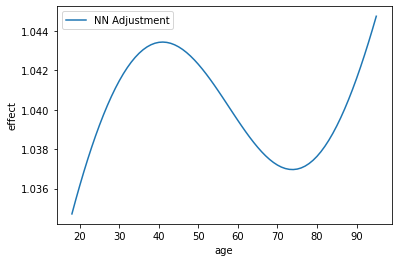

In [64]:
plt.plot(df['ageph'], df['cann_pred'], label = "NN Adjustment")
plt.xlabel('age')
plt.ylabel('effect')
plt.legend()
plt.show()

In [68]:
df = pd.DataFrame({'ageph':np.array(range(18,96))})
df['skip'] = gam_bs.predict(exog = pd.DataFrame(np.array(range(18,96))),  exog_smooth = np.array(range(18,96)))
df['cann_pred'] = np.log(cann.predict([tf.cast(df.ageph,dtype = tf.float32),tf.cast(df.skip,dtype = tf.float32)])); df.head()

,ageph,skip,cann_pred
0,18,0.319549,0.353673
1,19,0.303535,0.338374
2,20,0.288446,0.323970
3,21,0.274224,0.310402
4,22,0.260814,0.297615


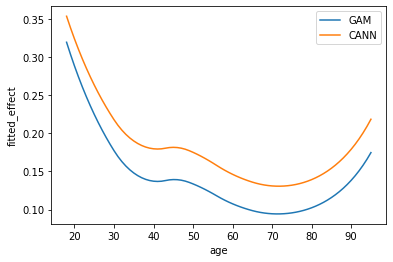

In [69]:
plt.plot(df['ageph'], df['skip'], label = "GAM")
plt.plot(df['ageph'], df['cann_pred'], label = "CANN")
plt.xlabel('age')
plt.ylabel('fitted_effect')
plt.legend()
plt.show()

### Claim severity modeling with neural nets

In [82]:
df_claims = train[train.nclaims > 0]; df_claims.head()

,id,nclaims,amount,avg,expo,coverage,fuel,use,fleet,sex,ageph,bm,agec,power,pc,town,long,lat
151350,151351,1,26140.570502,26140.570502,1.00000,TPL,gasoline,private,N,male,42,12,9,68,9100,SINT-NIK,4.150210,51.171487
63247,63248,1,311.949212,311.949212,1.00000,FO,gasoline,private,N,female,50,14,1,39,4100,SERAING,5.500567,50.583188
37122,37123,1,535.450014,535.450014,0.69863,TPL,gasoline,private,N,male,30,8,13,44,2800,MECHELEN,4.452854,51.035733
86659,86660,1,64.625842,64.625842,1.00000,TPL,gasoline,private,N,female,74,1,2,55,5570,BEAURAIN,4.905135,50.089954
9467,9468,1,1700.673527,1700.673527,1.00000,FO,diesel,private,N,female,36,8,1,60,1200,SINT-LAM,4.419542,50.848528


In [85]:
df_claims.shape

(13785, 18)

Let's model the log severity with a MSE loss:

In [86]:
nn_sev_log = tf.keras.models.Sequential()
nn_sev_log.add(tf.keras.layers.Dense(units = 1, activation = 'linear', input_shape = (1,), use_bias = False))
nn_sev_log.compile(optimizer = 'RMSprop', loss = 'mse')
nn_sev_log.fit(x = np.array(np.ones(df_claims.shape[0])),
              y = np.log(np.array(df_claims['avg'])),
              epochs = 100,
              batch_size = 128,
              validation_split = 0,
              verbose = 1)

Train on 13785 samples
Epoch 1/100
13785/13785 [==============================] - 0s 30us/sample - loss: 30.1449
Epoch 2/100
13785/13785 [==============================] - 0s 9us/sample - loss: 29.0103
Epoch 3/100
13785/13785 [==============================] - 0s 11us/sample - loss: 27.9062
Epoch 4/100
13785/13785 [==============================] - 0s 11us/sample - loss: 26.8239
Epoch 5/100
13785/13785 [==============================] - 0s 13us/sample - loss: 25.7683
Epoch 6/100
13785/13785 [==============================] - 0s 11us/sample - loss: 24.7313
Epoch 7/100
13785/13785 [==============================] - 0s 8us/sample - loss: 23.7192
Epoch 8/100
13785/13785 [==============================] - 0s 10us/sample - loss: 22.7303
Epoch 9/100
13785/13785 [==============================] - 0s 9us/sample - loss: 21.7672
Epoch 10/100
13785/13785 [==============================] - 0s 12us/sample - loss: 20.8245
Epoch 11/100
13785/13785 [==============================] - 0s 9us/sample - los

In [89]:
np.log(np.array(df_claims['avg']))

array([7.31612725, 7.26289458, 4.175876  , ..., 4.16861436, 8.80140121,
       6.91710904])

In [91]:
np.array(range(df_claims.shape[0]))

array([    0,     1,     2, ..., 13782, 13783, 13784])

In [96]:
np.float(np.exp(nn_sev_log.predict(tf.cast([1], dtype = tf.float32))))

453.4446716308594

In [97]:
df_claims['avg'].describe()

count    1.378500e+04
mean     1.649423e+03
std      1.865988e+04
min      2.478935e-02
25%      1.421917e+02
50%      5.345080e+02
75%      1.426379e+03
max      1.989568e+06
Name: avg, dtype: float64

In [98]:
def k_gamma(y_true, y_pred):
    y_true = tf.cast(y_true, dtype = tf.float32)
    y_pred = tf.cast(y_pred, dtype = tf.float32)
    return ((y_true - y_pred) / y_pred) - tf.math.log(y_true / y_pred)

In [99]:
nn_sev_gamma = tf.keras.models.Sequential()
nn_sev_gamma.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', input_shape = (1,), use_bias = False))
nn_sev_gamma.compile(optimizer = 'RMSprop', loss = k_gamma)
nn_sev_gamma.fit(x = np.ones(df_claims.shape[0]),
                 y = np.array(df_claims['avg']),
                 epochs = 100,
                 batch_size = 128,
                 validation_split = 0)

Train on 13785 samples
Epoch 1/100
13785/13785 [==============================] - 0s 29us/sample - loss: 1419.9667
Epoch 2/100
13785/13785 [==============================] - 0s 10us/sample - loss: 1313.5549
Epoch 3/100
13785/13785 [==============================] - 0s 8us/sample - loss: 1187.1669
Epoch 4/100
13785/13785 [==============================] - 0s 9us/sample - loss: 1097.9775
Epoch 5/100
13785/13785 [==============================] - 0s 9us/sample - loss: 1006.4835
Epoch 6/100
13785/13785 [==============================] - 0s 10us/sample - loss: 912.7667
Epoch 7/100
13785/13785 [==============================] - 0s 9us/sample - loss: 846.8450
Epoch 8/100
13785/13785 [==============================] - 0s 9us/sample - loss: 771.7519
Epoch 9/100
13785/13785 [==============================] - 0s 8us/sample - loss: 706.7449
Epoch 10/100
13785/13785 [==============================] - 0s 8us/sample - loss: 643.3032
Epoch 11/100
13785/13785 [==============================] - 0s 9us/s

In [104]:
np.float(nn_sev_gamma.predict(tf.cast([1], dtype = tf.float32)))

1440.118896484375

In [105]:
np.mean(df_claims[df_claims['avg'] < 30000]['avg'])

1159.6594613350771